In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")

In [2]:
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
from rule_utils import get_rule_img, get_obj_list, get_rule_list
from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from tqdm import tqdm
from collections import defaultdict

In [4]:
import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


In [5]:
from rule_new_utils import check_r3_r2_batch

def infer_rule_from_sample_batch(sample_batch):
    # if not int convert to int
    sample_batch = sample_batch.round().int()
    sample_batch = sample_batch.view(-1, 3, 3, 3, 9) 
    sample_batch = einops.rearrange(sample_batch, 
        "B attr row h (panel w) -> B row panel (h w) attr", 
        panel=3, w=3, h=3, attr=3)
    r3_list, r2_list, rule_col = check_r3_r2_batch(sample_batch)
    return r3_list, r2_list, rule_col

In [6]:
!cd $STORE_DIR/DL_Projects/mini_edm/exps;pwd

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps


In [49]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [8]:
!ls {exprooot}

BaseBlnr_RAVEN10_abstract_20240212-2142
BaseBlnr_RAVEN10_abstract_onehot_20240212-2143
BaseBlnrX3_new_RAVEN10_abstract_20240313-1736
BaseBlnrX3_new_RAVEN10_abstract_onehot_20240313-1736
base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
Base_RAVEN10_abstract_20240212-2139
base_RAVEN10_abstract_onehot_20240201-0147
Base_RAVEN10_abstract_onehot_20240212-2140
BBigBlnrX3_new_RAVEN10_abstract_20240313-1809
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240313-1810
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240314-0112
BBigBlnrX3_RAVEN10_abstract_20240305-2341
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
BigBlnrX3_new_RAVEN10_abstract_20240313-1753
BigBlnrX3_new_RAVEN10_abstract_20240315-1328
BigBlnrX3_new_RAVEN10_

In [62]:
ckptdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240315-1327/checkpoints'

: 

In [61]:
!ls {ckptdir}

ema_100000.pth	ema_220000.pth	ema_360000.pth	ema_480000.pth	ema_60000.pth
ema_120000.pth	ema_240000.pth	ema_380000.pth	ema_500000.pth	ema_620000.pth
ema_140000.pth	ema_260000.pth	ema_400000.pth	ema_520000.pth	ema_640000.pth
ema_160000.pth	ema_280000.pth	ema_40000.pth	ema_540000.pth	ema_660000.pth
ema_180000.pth	ema_300000.pth	ema_420000.pth	ema_560000.pth	ema_680000.pth
ema_200000.pth	ema_320000.pth	ema_440000.pth	ema_580000.pth	ema_700000.pth
ema_20000.pth	ema_340000.pth	ema_460000.pth	ema_600000.pth	ema_80000.pth


In [47]:
DATASET="RAVEN10_abstract"
# --layers_per_block 2 --model_channels 128 --channel_mult 1 2 4 --attn_resolutions 9 3 --train_batch_size 256 --spatial_matching bilinear
config_ft = get_default_config(DATASET, layers_per_block=2, 
                               model_channels=128, 
                               channel_mult=[1, 2, 4], 
                               attn_resolutions=[9, 3], 
                               spatial_matching="bilinear")
device = "cuda"

In [11]:
Xmean = torch.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
Xstd = torch.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [48]:
epoch = 700000
expname = "WideBlnrX3_new_RAVEN10_abstract_20240315-1327"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)
edm, model_EDM = create_edm_new(ckptdir + f"/ema_{epoch}.pth", config_ft, device) 

FeatureFetcher hooks all freed


### Test sampling and accuracy

In [13]:
latents = torch.randn(1024, 3, 9, 9).to(device)
samples = edm_sampler(edm, latents, num_steps=40)
samples = samples * Xstd + Xmean

In [14]:
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples.cpu())

In [15]:
sum([len(r3)>0 for r3 in r3_list]), sum([len(r2)>0 for r2 in r2_list]), len(rule_col)

(451, 217, 1024)

In [16]:
np.mean([len(rl)>0 for rl in sum(rule_col,[])])

0.7112630208333334

### Training data

In [17]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

In [18]:
print(train_sample_img[0,0])

tensor([[[ 5,  5,  5,  5,  5, -1,  5, -1,  5],
         [ 5,  5,  5, -1, -1,  5,  5,  5,  5],
         [ 5,  5,  5,  5, -1, -1, -1,  5,  5],
         [-1,  6,  6,  6, -1, -1,  6,  6,  6],
         [-1, -1, -1, -1,  6,  6,  6,  6,  6],
         [-1,  6,  6,  6,  6, -1, -1,  6,  6],
         [ 2, -1,  2,  2,  2,  2, -1, -1,  2],
         [ 2,  2, -1,  2, -1, -1, -1, -1, -1],
         [ 2,  2,  2, -1,  2,  2,  2,  2, -1]],

        [[ 4,  4,  4,  2,  2, -1,  9, -1,  9],
         [ 4,  4,  4, -1, -1,  2,  9,  9,  9],
         [ 4,  4,  4,  2, -1, -1, -1,  9,  9],
         [-1,  5,  1,  5, -1, -1,  7,  1,  5],
         [-1, -1, -1, -1,  0,  1,  7,  4,  0],
         [-1,  3,  1,  8,  2, -1, -1,  7,  6],
         [ 5, -1,  5,  3,  3,  3, -1, -1,  6],
         [ 5,  5, -1,  3, -1, -1, -1, -1, -1],
         [ 5,  5,  5, -1,  3,  3,  6,  6, -1]],

        [[ 4,  8,  4,  5,  0, -1,  6, -1,  4],
         [ 0,  5,  4, -1, -1,  1,  2,  5,  8],
         [ 7,  3,  1,  2, -1, -1, -1,  8,  2],
         

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


### Hook model and retrieve feature

In [50]:
get_module_name_shapes(model_EDM, inputs_list=[th.randn(2, 3, 9, 9).to(device), th.rand(2, ).to(device), None], deepest=3);

------------------------------------------------------------------------------------------------------------------------------------------------------
      Layer Id                                           inshape                    outshape                            Type   Module Path                      
        0                                             (2, 3, 9, 9)                (2, 3, 9, 9)                         [Input]   Image                            
        1                                                   [(2,)]                    (2, 128)           [PositionalEmbedding]   .map_noise                       
        2                                               [(2, 128)]                    (2, 512)                        [Linear]   .map_layer0                      
        3                                               [(2, 512)]                    (2, 512)                        [Linear]   .map_layer1                      
        4                           

In [51]:
list(model_EDM.enc)

['9x9_conv',
 '9x9_block0',
 '9x9_block1',
 '3x3_down',
 '3x3_block0',
 '3x3_block1',
 '1x1_down',
 '1x1_block0',
 '1x1_block1']

In [52]:
list(model_EDM.dec)

['1x1_in0',
 '1x1_in1',
 '1x1_block0',
 '1x1_block1',
 '1x1_block2',
 '3x3_up',
 '3x3_block0',
 '3x3_block1',
 '3x3_block2',
 '9x9_up',
 '9x9_block0',
 '9x9_block1',
 '9x9_block2',
 '9x9_aux_norm',
 '9x9_aux_conv']

In [59]:
fetcher = featureFetcher_module()
for blockname in list(model_EDM.enc):
    fetcher.record_module(model_EDM.enc[blockname], target_name=f"enc.{blockname}")
for blockname in list(model_EDM.dec):
    fetcher.record_module(model_EDM.dec[blockname], target_name=f"dec.{blockname}")
# fetcher.record_module(model.blocks[11], target_name="blocks.11")
# for i in range(12):
#     fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")
# fetcher.record_module(model.enc["9x9_conv"], target_name="enc.9x9_conv",)
# fetcher.record_module(model.enc["9x9_block0"], target_name="enc.9x9_block0",)
# fetcher.record_module(model.enc["9x9_block1"], target_name="enc.9x9_block1",)
# fetcher.record_module(model.enc["3x3_down"], target_name="enc.3x3_down",)
# fetcher.record_module(model.enc["3x3_block0"], target_name="enc.3x3_block0",)
# fetcher.record_module(model.enc["3x3_block1"], target_name="enc.3x3_block1",)
# fetcher.record_module(model.enc["1x1_down"], target_name="enc.1x1_down",)
# fetcher.record_module(model.enc["1x1_block0"], target_name="enc.1x1_block0",)
# fetcher.record_module(model.enc["1x1_block1"], target_name="enc.1x1_block1",)
# fetcher.record_module(model.dec["1x1_in0"], target_name="dec.1x1_in0",)
# fetcher.record_module(model.dec["1x1_in1"], target_name="dec.1x1_in1",)
# fetcher.record_module(model.dec["1x1_block0"], target_name="dec.1x1_block0",)
# fetcher.record_module(model.dec["1x1_block1"], target_name="dec.1x1_block1",)
# fetcher.record_module(model.dec["1x1_block2"], target_name="dec.1x1_block2",)
# fetcher.record_module(model.dec["3x3_up"], target_name="dec.3x3_up",)
# fetcher.record_module(model.dec["3x3_block0"], target_name="dec.3x3_block0",)
# fetcher.record_module(model.dec["3x3_block1"], target_name="dec.3x3_block1",)
# fetcher.record_module(model.dec["3x3_block2"], target_name="dec.3x3_block2",)
# fetcher.record_module(model.dec["9x9_up"], target_name="dec.9x9_up",)
# fetcher.record_module(model.dec["9x9_block0"], target_name="dec.9x9_block0",)
# fetcher.record_module(model.dec["9x9_block1"], target_name="dec.9x9_block1",)
# fetcher.record_module(model.dec["9x9_block2"], target_name="dec.9x9_block2",)

In [24]:
# layerkey = "blocks.11"
# fetcher = featureFetcher_module()
# for i in [0,2,5,8,11]: #range(12):
#     fetcher.record_module(model.blocks[i], target_name=f"blocks.{i}")
    
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, drop_last=False)
t_scalar = 0.1
feature_col = defaultdict(list)
for X_batch, y_batch in tqdm(train_loader):
    # model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model_EDM(X_batch_norm, t_vec, None)
    feature_col["input"].append(X_batch.float())
    for key, activations in fetcher.activations.items():
        feature_col[key].append(activations)
for key in feature_col.keys():
    feature_col[key] = th.cat(feature_col[key], dim=0)
    print(key, feature_col[key].shape)


feature_col_test = defaultdict(list)
for X_batch, y_batch in tqdm(test_loader):
    # model_kwargs = dict(y=th.zeros(X_batch.shape[0], dtype=torch.int, device="cuda"))
    t_vec = th.ones(X_batch.shape[0], dtype=torch.float, device="cuda") * t_scalar
    X_batch_norm = (X_batch.cuda().float() - dataset_Xmean) / dataset_Xstd
    with th.no_grad():
        model_EDM.forward(X_batch_norm, t_vec, None)
    feature_col_test["input"].append(X_batch.float())
    for key, activations in fetcher.activations.items():
        feature_col_test[key].append(activations)
        
for key in feature_col_test.keys():
    feature_col_test[key] = th.cat(feature_col_test[key], dim=0)
    print(key, feature_col_test[key].shape)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:43<00:00,  1.37it/s]


enc.9x9_conv torch.Size([120000, 128, 9, 9])
enc.9x9_block0 torch.Size([120000, 128, 9, 9])
enc.9x9_block1 torch.Size([120000, 128, 9, 9])
enc.3x3_down torch.Size([120000, 128, 3, 3])
enc.3x3_block0 torch.Size([120000, 256, 3, 3])
enc.3x3_block1 torch.Size([120000, 256, 3, 3])
enc.1x1_down torch.Size([120000, 256, 1, 1])
enc.1x1_block0 torch.Size([120000, 512, 1, 1])
enc.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_in0 torch.Size([120000, 512, 1, 1])
dec.1x1_in1 torch.Size([120000, 512, 1, 1])
dec.1x1_block0 torch.Size([120000, 512, 1, 1])
dec.1x1_block1 torch.Size([120000, 512, 1, 1])
dec.1x1_block2 torch.Size([120000, 512, 1, 1])
dec.3x3_up torch.Size([120000, 512, 1, 1])
dec.3x3_block0 torch.Size([120000, 256, 3, 3])
dec.3x3_block1 torch.Size([120000, 256, 3, 3])
dec.3x3_block2 torch.Size([120000, 256, 3, 3])
dec.9x9_up torch.Size([120000, 256, 7, 7])
dec.9x9_block0 torch.Size([120000, 128, 9, 9])
dec.9x9_block1 torch.Size([120000, 128, 9, 9])
dec.9x9_block2 torch.Size([120000

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


enc.9x9_conv torch.Size([40000, 128, 9, 9])
enc.9x9_block0 torch.Size([40000, 128, 9, 9])
enc.9x9_block1 torch.Size([40000, 128, 9, 9])
enc.3x3_down torch.Size([40000, 128, 3, 3])
enc.3x3_block0 torch.Size([40000, 256, 3, 3])
enc.3x3_block1 torch.Size([40000, 256, 3, 3])
enc.1x1_down torch.Size([40000, 256, 1, 1])
enc.1x1_block0 torch.Size([40000, 512, 1, 1])
enc.1x1_block1 torch.Size([40000, 512, 1, 1])
dec.1x1_in0 torch.Size([40000, 512, 1, 1])
dec.1x1_in1 torch.Size([40000, 512, 1, 1])
dec.1x1_block0 torch.Size([40000, 512, 1, 1])
dec.1x1_block1 torch.Size([40000, 512, 1, 1])
dec.1x1_block2 torch.Size([40000, 512, 1, 1])
dec.3x3_up torch.Size([40000, 512, 1, 1])
dec.3x3_block0 torch.Size([40000, 256, 3, 3])
dec.3x3_block1 torch.Size([40000, 256, 3, 3])
dec.3x3_block2 torch.Size([40000, 256, 3, 3])
dec.9x9_up torch.Size([40000, 256, 7, 7])
dec.9x9_block0 torch.Size([40000, 128, 9, 9])
dec.9x9_block1 torch.Size([40000, 128, 9, 9])
dec.9x9_block2 torch.Size([40000, 128, 9, 9])


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


# Define the training loop
def train_model(model, train_loader, num_epochs, learning_rate, print_every=50,
                eval_every=500, eval_func=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_record = []
    test_record = []
    for epoch in range(num_epochs):
        acc_total = 0
        cnt_total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc_cnt = (outputs.argmax(dim=1) == labels).sum().item()
            acc_total += acc_cnt
            cnt_total += len(labels)
        accuracy = acc_total / cnt_total
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
        train_record.append((epoch, loss.item(), accuracy))
        if ((epoch + 1) % eval_every == 0 or epoch == num_epochs - 1) and eval_func is not None:
            test_acc, _ = eval_func(model)
            test_record.append((epoch, test_acc))
    train_record = pd.DataFrame(train_record, columns=["epoch", "loss", "accuracy"])
    test_record = pd.DataFrame(test_record, columns=["epoch", "accuracy"])
    return train_record, test_record


def test_model(model, test_loader):
    acc_total = 0
    cnt_total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        with th.no_grad():
            outputs = model(inputs)
        pred_cls = outputs.argmax(dim=1)
        acc_cnt = (pred_cls == labels).sum().item()
        acc_total += acc_cnt
        cnt_total += len(labels)
    accuracy = acc_total / cnt_total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy, pred_cls


def fit_SGD_linear_classifier(train_X, train_y, test_X=None, test_y=None, 
                              num_classes=40, 
                              batch_size=1024, num_epochs=100, 
                              learning_rate = 0.001, print_every=100, eval_every=500,):
    # Define the linear classifier model
    input_size = train_X.shape[1]
    model = LinearClassifier(input_size, num_classes).to("cuda")
    if batch_size is None:
        feat_loader = [(train_X.to("cuda"), train_y.to("cuda"))]
    else:
        feat_dataset = TensorDataset(train_X.to("cuda"), train_y.to("cuda")) # .to("cuda")
        feat_loader = DataLoader(feat_dataset, batch_size=batch_size, shuffle=True,
                             drop_last=True) # pin_memory=True, num_workers=
    
    if test_X is not None and test_y is not None:
        if batch_size is None:
            test_feat_loader = [(test_X.to("cuda"), test_y.to("cuda"))]
        else:
            test_dataset = TensorDataset(test_X.to("cuda"), test_y.to("cuda")) # .to("cuda")
            test_feat_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Define the training loop
    train_record, test_record = train_model(model, feat_loader, num_epochs, learning_rate, print_every=print_every, eval_every=eval_every,
                eval_func=lambda model: test_model(model, test_feat_loader) if test_feat_loader is not None else None)
    # Define the testing loop
    test_acc, pred_cls = test_model(model, test_feat_loader)
    results = edict()
    results.train_record = train_record
    results.test_record = test_record
    results.test_acc = test_acc
    results.pred_cls = pred_cls
    return model, results


In [58]:
[*fetcher.activations.keys()]

[]

In [ ]:
'enc.9x9_conv',
'enc.3x3_down',
'enc.1x1_down',
'enc.1x1_block1',
'dec.1x1_in1',
'dec.1x1_block2',
'dec.3x3_up',
'dec.3x3_block2',
'dec.9x9_up',
'dec.9x9_block2'

In [42]:
figdir = r"/n/home12/binxuwang/Github/DiffusionReasoning/Figures_repr_classify"
repr_expdir = join(expdir, "repr_classifier")
os.makedirs(repr_expdir, exist_ok=True)

In [60]:
list(feature_col)

['enc.9x9_conv',
 'enc.9x9_block0',
 'enc.9x9_block1',
 'enc.3x3_down',
 'enc.3x3_block0',
 'enc.3x3_block1',
 'enc.1x1_down',
 'enc.1x1_block0',
 'enc.1x1_block1',
 'dec.1x1_in0',
 'dec.1x1_in1',
 'dec.1x1_block0',
 'dec.1x1_block1',
 'dec.1x1_block2',
 'dec.3x3_up',
 'dec.3x3_block0',
 'dec.3x3_block1',
 'dec.3x3_block2',
 'dec.9x9_up',
 'dec.9x9_block0',
 'dec.9x9_block1',
 'dec.9x9_block2']

torch.Size([120000, 512]) torch.Size([512]) torch.Size([2304, 512])
Epoch [1/5000], Loss: 3.8651, Accuracy: 0.0240
Epoch [250/5000], Loss: 0.3718, Accuracy: 0.8815
Epoch [500/5000], Loss: 0.3188, Accuracy: 0.8932
Epoch [750/5000], Loss: 0.2957, Accuracy: 0.8986
Epoch [1000/5000], Loss: 0.2819, Accuracy: 0.9021
Test Accuracy: 0.8494
Epoch [1250/5000], Loss: 0.2725, Accuracy: 0.9046
Epoch [1500/5000], Loss: 0.2655, Accuracy: 0.9064
Epoch [1750/5000], Loss: 0.2601, Accuracy: 0.9079
Epoch [2000/5000], Loss: 0.2558, Accuracy: 0.9092
Test Accuracy: 0.8498
Epoch [2250/5000], Loss: 0.2522, Accuracy: 0.9102
Epoch [2500/5000], Loss: 0.2492, Accuracy: 0.9109
Epoch [2750/5000], Loss: 0.2466, Accuracy: 0.9117
Epoch [3000/5000], Loss: 0.2444, Accuracy: 0.9124
Test Accuracy: 0.8493
Epoch [3250/5000], Loss: 0.2425, Accuracy: 0.9130
Epoch [3500/5000], Loss: 0.2408, Accuracy: 0.9135
Epoch [3750/5000], Loss: 0.2392, Accuracy: 0.9140
Epoch [4000/5000], Loss: 0.2378, Accuracy: 0.9142
Test Accuracy: 0.8480


NameError: name 'figdir' is not defined

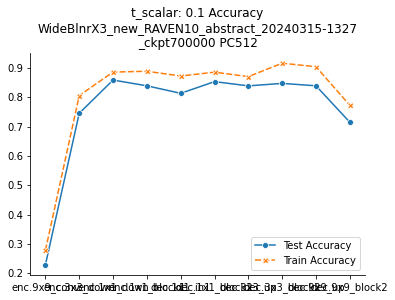

In [41]:
from stats_plot_utils import saveallforms
import time
PC_dim = 512
noPCA = False
learning_rate = 0.0005 if noPCA else 0.005
t_str = f"{t_scalar:.2f}".replace(".", "_")
ckpt_str = f"_ckpt{epoch}"
model_PCA_col = {}
PC_proj_col = {}
results_col = {}
for layerkey in ['enc.9x9_conv',
                'enc.3x3_down',
                'enc.1x1_down',
                'enc.1x1_block1',
                'dec.1x1_in1',
                'dec.1x1_block2',
                'dec.3x3_up',
                'dec.3x3_block2',
                'dec.9x9_up',
                'dec.9x9_block2', ]: # 
    t0 = time.time()
    featmat = feature_col[layerkey].reshape(len(train_dataset),-1)
    featmat_test = feature_col_test[layerkey].reshape(len(test_dataset),-1)
    featmean = featmat.mean(dim=0)
    featdim = featmat.shape[1]
    t1 = time.time()
    if noPCA or featdim <= PC_dim:
        feat_PCA = (featmat - featmean[None,]).cuda()
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() 
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
    else:
        U, S, V = torch.pca_lowrank((featmat - featmean[None,]).cuda(), q=PC_dim, center=False, niter=3)
        print(U.shape, S.shape, V.shape)
        del U, S
        torch.cuda.empty_cache()
        feat_PCA = (featmat - featmean[None,]).cuda() @ V
        feat_PCA_std = feat_PCA.std(dim=0)
        feat_PCA = feat_PCA / feat_PCA_std[None,]
        feat_PCA_test = (featmat_test - featmean[None,]).cuda() @ V
        feat_PCA_test = feat_PCA_test / feat_PCA_std[None,]
        torch.cuda.empty_cache()
        V = V.cpu()
    t2 = time.time()
    model, results_dict = fit_SGD_linear_classifier(feat_PCA, y_train, feat_PCA_test, y_test,
                                    num_classes=40, batch_size=None, num_epochs=5000, print_every=250, 
                                    eval_every=1000, learning_rate=learning_rate)
    t3 = time.time()
    print(f"Layer {layerkey} PCA time: {t1-t0:.2f}, PCA transform time: {t2-t1:.2f}, training time: {t3-t2:.2f}")
    model_PCA_col[layerkey] = model
    if noPCA:
        PC_proj_col[layerkey] = (None, featmean.cpu(), feat_PCA_std.cpu())
    else:
        PC_proj_col[layerkey] = (V.cpu(), featmean.cpu(), feat_PCA_std.cpu())
    results_col[layerkey] = results_dict
    del feat_PCA, feat_PCA_test
    th.cuda.empty_cache()
    
pkl.dump(results_col, open(join(repr_expdir,f"results_col_t{t_str}_PC{PC_dim}{ckpt_str}.pkl"), "wb"))
pkl.dump(PC_proj_col, open(join(repr_expdir,f"PC_proj_col_t{t_str}_PC{PC_dim}{ckpt_str}.pkl"), "wb"))
pkl.dump(model_PCA_col, open(join(repr_expdir,f"model_PCA_col_t{t_str}_PC{PC_dim}{ckpt_str}.pkl"), "wb"))

test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]

plt.figure(figsize=(6, 4))
sns.lineplot(data=syn_df, markers=True)
plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} PC{PC_dim}")
saveallforms([repr_expdir, figdir],f"{expname}_t{t_str}_PC{PC_dim}{ckpt_str}_accuracy")
plt.show()

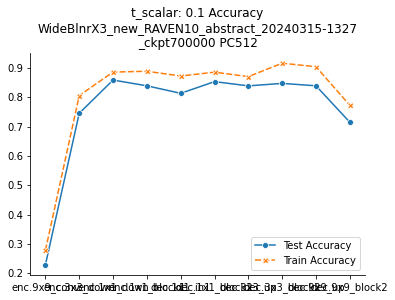

In [45]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=syn_df, markers=True)
plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} PC{PC_dim}")
saveallforms([repr_expdir, figdir],f"{expname}_t{t_str}_PC{PC_dim}{ckpt_str}_accuracy")
plt.show()

In [55]:
results_col[key]

{'train_record':       epoch      loss  accuracy
 0         0  3.856684  0.024908
 1         1  3.675911  0.048450
 2         2  3.507413  0.088883
 3         3  3.351031  0.143275
 4         4  3.206305  0.199783
 ...     ...       ...       ...
 4995   4995  0.717637  0.772233
 4996   4996  0.717634  0.772242
 4997   4997  0.717632  0.772233
 4998   4998  0.717629  0.772233
 4999   4999  0.717626  0.772275
 
 [5000 rows x 3 columns],
 'test_record':    epoch  accuracy
 0    999  0.694150
 1   1999  0.707625
 2   2999  0.712950
 3   3999  0.714650
 4   4999  0.714825,
 'test_acc': 0.714825,
 'pred_cls': tensor([ 0,  0,  0,  ..., 39, 39, 39], device='cuda:0')}

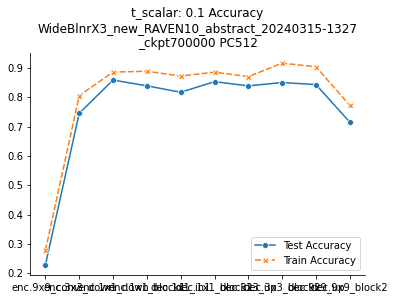

In [56]:
test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
syn_df.columns = ["Test Accuracy", "Train Accuracy"]

plt.figure(figsize=(6, 4))
sns.lineplot(data=syn_df, markers=True)
plt.title(f"t_scalar: {t_scalar} Accuracy\n{expname}\n{ckpt_str} PC{PC_dim}")
# saveallforms([repr_expdir, figdir],f"{expname}_t{t_str}_PC{PC_dim}{ckpt_str}_accuracy")
plt.show()

In [39]:
feature_col[layerkey].reshape(len(train_dataset),-1)

tensor([[ 3.5380,  3.8611,  3.6785,  ...,  1.3311, 10.8773,  1.1613],
        [ 2.6661,  2.7481,  3.9891,  ..., -4.2326,  7.9226,  0.2241],
        [ 2.9535,  2.5597,  1.8490,  ...,  1.8839, 10.1603, -2.0479],
        ...,
        [ 5.4787,  4.8186,  5.5408,  ..., -1.9111,  1.2289,  0.0764],
        [ 2.8093, -1.0542,  3.9364,  ...,  2.2130,  2.9810, -0.6629],
        [ 4.0964,  3.1155,  2.2594,  ...,  0.1943, -1.2307, -0.2258]])